# News Recommender
> Finding best news to recommender using NCF model, training in pytorch lightening on MIND news dataset

- toc: true
- badges: true
- comments: true
- categories: [NCF, News, PytorchLightning, Pytorch, Visualization, Wordcloud, NLP, Transformers]
- image:

## Setup

In [2]:
#hide
!pip install -q sentence-transformers
!pip install -q pytorch-lightning
!pip install -q scikit-plot
!pip install -q wordcloud

     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 2.6 MB 13.4 MB/s 
     |████████████████████████████████| 1.2 MB 58.3 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 895 kB 55.4 MB/s 
     |████████████████████████████████| 636 kB 57.4 MB/s 
     |████████████████████████████████| 3.3 MB 53.0 MB/s 
     |████████████████████████████████| 813 kB 7.9 MB/s 
     |████████████████████████████████| 234 kB 25.3 MB/s 
     |████████████████████████████████| 118 kB 30.2 MB/s 
     |████████████████████████████████| 829 kB 29.4 MB/s 
     |████████████████████████████████| 10.6 MB 42.2 MB/s 
     |████████████████████████████████| 1.3 MB 54.7 MB/s 
     |████████████████████████████████| 294 kB 60.8 MB/s 
     |████████████████████████████████| 142 kB 69.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [3]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scikitplot as skplt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)
%reload_ext tensorboard
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [4]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython          : 5.5.0
torch            : 1.9.0+cu102
pandas           : 1.1.5
scikitplot       : 0.3.7
matplotlib       : 3.2.2
pytorch_lightning: 1.3.8
numpy            : 1.19.5



## Data Loading

In [18]:
#hide
!wget https://github.com/sparsh-ai/reco-data/raw/newsdata/newsdata/news_text.parquet.gzip
!wget https://github.com/sparsh-ai/reco-data/raw/newsdata/newsdata/user_news_clicks.parquet.gzip

--2021-07-25 06:03:15--  https://github.com/sparsh-ai/reco-data/raw/newsdata/newsdata/news_text.parquet.gzip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sparsh-ai/reco-data/newsdata/newsdata/news_text.parquet.gzip [following]
--2021-07-25 06:03:15--  https://raw.githubusercontent.com/sparsh-ai/reco-data/newsdata/newsdata/news_text.parquet.gzip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6567146 (6.3M) [application/octet-stream]
Saving to: ‘news_text.parquet.gzip.1’

news_text.parquet.g 100%[===================>]   6.26M  --.-KB/s    in 0.03s   

2021-07-25 06:03:15 (203 MB/s) - ‘news_tex

In [19]:
news_df = pd.read_parquet("news_text.parquet.gzip")
news_df['title'] = news_df['title'].fillna("")
news_df['title'] = news_df['title'].str.lower()
news_df['title'] = news_df.apply(lambda z: z.get("title", "")+"." if z.get("title") and z.get("title", "")[-1] not in string.punctuation else z.get("title"), axis=1)
news_df['abstract'] = news_df['abstract'].fillna("")
news_df['abstract'] = news_df['abstract'].str.lower()
news_df['text'] = news_df.apply(lambda z: z.get("title", "")+ " " + z.get("abstract", ""), axis=1)
news_df.head()

,news_id,title,abstract,category,text
0,N55528,"the brands queen elizabeth, prince charles, an...","shop the notebooks, jackets, and more that the...",lifestyle,"the brands queen elizabeth, prince charles, an..."
1,N19639,50 worst habits for belly fat.,these seemingly harmless habits are holding yo...,health,50 worst habits for belly fat. these seemingly...
2,N61837,the cost of trump's aid freeze in the trenches...,lt. ivan molchanets peeked over a parapet of s...,news,the cost of trump's aid freeze in the trenches...
3,N53526,i was an nba wife. here's how it affected my m...,"i felt like i was a fraud, and being an nba wi...",health,i was an nba wife. here's how it affected my m...
4,N38324,"how to get rid of skin tags, according to a de...","they seem harmless, but there's a very good re...",health,"how to get rid of skin tags, according to a de..."


In [20]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   news_id   51282 non-null  object
 1   title     51282 non-null  object
 2   abstract  51282 non-null  object
 3   category  51282 non-null  object
 4   text      51282 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [22]:
print("unique items:", len(news_df.news_id.unique()))
print("unique categories:", len(news_df.category.unique()))

unique items: 51282
unique categories: 17


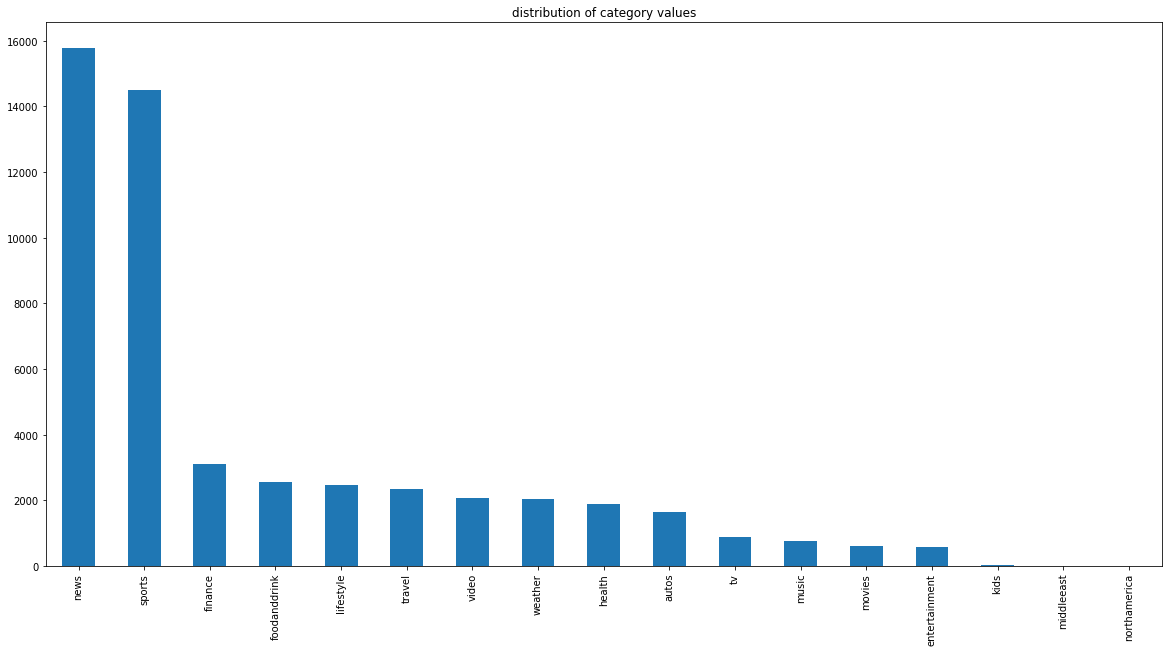

In [23]:
news_df.category.value_counts().plot(kind='bar', title='distribution of category values', figsize=(20, 10))

In [25]:
clicks_df = pd.read_parquet("user_news_clicks.parquet.gzip")
clicks_df

,user_id,item,click
0,U13740,N55189,1
1,U13740,N42782,1
2,U13740,N34694,1
3,U13740,N45794,1
4,U13740,N18445,1
...,...,...,...
10951078,U64800,N48742,1
10951079,U64800,N61233,0
10951080,U64800,N33828,1
10951081,U64800,N19661,0


In [26]:
print("unique users: ", len(clicks_df.user_id.unique()))
print("unique items: ", len(clicks_df.item.unique()))
print("unique interactions: ",len(clicks_df.click.unique()))

unique users:  50000
unique items:  51282
unique interactions:  2


In [27]:
clicks_df.shape, clicks_df.drop_duplicates(subset=["user_id", "item", "click"]).shape

((10951083, 3), (5947854, 3))

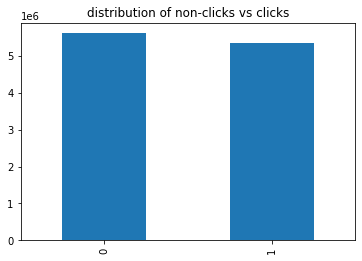

In [29]:
clicks_df.click.value_counts().plot(kind='bar', title='distribution of non-clicks vs clicks');

## Encoding

### Encode news articles text with embeddings from SentenceTransformers

In [30]:
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model = SentenceTransformer('average_word_embeddings_komninos')

#Our sentences we like to encode
sentences = news_df['text'].tolist()

# run the encoder
embeddings = model.encode(sentences)

news_df['text_embedding'] = embeddings.tolist()

print(embeddings.shape)

news_df.head()


(51282, 300)


,news_id,title,abstract,category,text,text_embedding
0,N55528,"the brands queen elizabeth, prince charles, an...","shop the notebooks, jackets, and more that the...",lifestyle,"the brands queen elizabeth, prince charles, an...","[-0.018122460693120956, 0.1401648372411728, -0..."
1,N19639,50 worst habits for belly fat.,these seemingly harmless habits are holding yo...,health,50 worst habits for belly fat. these seemingly...,"[0.15166886150836945, -0.08737953752279282, 0...."
2,N61837,the cost of trump's aid freeze in the trenches...,lt. ivan molchanets peeked over a parapet of s...,news,the cost of trump's aid freeze in the trenches...,"[0.195026695728302, 0.0307389535009861, 0.0026..."
3,N53526,i was an nba wife. here's how it affected my m...,"i felt like i was a fraud, and being an nba wi...",health,i was an nba wife. here's how it affected my m...,"[0.008694147691130638, 0.1383575052022934, 0.0..."
4,N38324,"how to get rid of skin tags, according to a de...","they seem harmless, but there's a very good re...",health,"how to get rid of skin tags, according to a de...","[0.1467491239309311, 0.02420864813029766, 0.16..."


### Encode news category column

In [32]:
news_category_encoder = LabelEncoder()
news_df['category_encoded'] = news_category_encoder.fit_transform(news_df["category"])
news_dict = {r['news_id']: r for r in news_df.to_dict("rows")}
len(news_dict)
news_df.head()

,news_id,title,abstract,category,text,text_embedding,category_encoded
0,N55528,"the brands queen elizabeth, prince charles, an...","shop the notebooks, jackets, and more that the...",lifestyle,"the brands queen elizabeth, prince charles, an...","[-0.018122460693120956, 0.1401648372411728, -0...",6
1,N19639,50 worst habits for belly fat.,these seemingly harmless habits are holding yo...,health,50 worst habits for belly fat. these seemingly...,"[0.15166886150836945, -0.08737953752279282, 0....",4
2,N61837,the cost of trump's aid freeze in the trenches...,lt. ivan molchanets peeked over a parapet of s...,news,the cost of trump's aid freeze in the trenches...,"[0.195026695728302, 0.0307389535009861, 0.0026...",10
3,N53526,i was an nba wife. here's how it affected my m...,"i felt like i was a fraud, and being an nba wi...",health,i was an nba wife. here's how it affected my m...,"[0.008694147691130638, 0.1383575052022934, 0.0...",4
4,N38324,"how to get rid of skin tags, according to a de...","they seem harmless, but there's a very good re...",health,"how to get rid of skin tags, according to a de...","[0.1467491239309311, 0.02420864813029766, 0.16...",4


### Encode user_id and item_id

In [33]:
label_encoders = {}
label_encoders["user_id"] = LabelEncoder()
label_encoders["item"] = LabelEncoder()
clicks_df["user_id_encoded"] = label_encoders["user_id"].fit_transform(clicks_df["user_id"])
clicks_df["item_id_encoded"] = label_encoders["item"].fit_transform(clicks_df["item"])
clicks_df.head()

,user_id,item,click,user_id_encoded,item_id_encoded
0,U13740,N55189,1,2246,39409
1,U13740,N42782,1,2246,28620
2,U13740,N34694,1,2246,21520
3,U13740,N45794,1,2246,31231
4,U13740,N18445,1,2246,7374


## Data Preparation

- Random Sampling data for faster training with limited hardware resources
- There are lots of user-item interactions with more than one event, to keep it simple dropping these duplicates from the data as we are using these interactions as implicit feedback. This will also prevent training data leakage 
- Train and Test split will be done randomly as we don't have any timestamp values for the user-item interactions to split based on chronology of events.
- Not going for negative sampling to keep it simple here. The distribution of clicks vs non-clicks looks balanced already.

In [34]:
traindf = clicks_df.drop_duplicates(subset=["user_id", "item", "click"])
traindf = traindf.sample(frac=0.4)
testdf = traindf.sample(frac=0.025)
traindf = traindf.drop(testdf.index)
traindf.shape, testdf.shape

((2319663, 5), (59479, 5))

In [35]:
traindf.click.value_counts()

0    1872379
1     447284
Name: click, dtype: int64

In [36]:
testdf.click.value_counts()

0    48033
1    11446
Name: click, dtype: int64

## Pytorch Dataset

In [37]:
class MINDTrainDataset(Dataset):
    """
    PyTorch Dataset for Training MIND dataset
    """

    def __init__(self, interactions, all_news_ids):
        """
        Args:
        interactions (pd.DataFrame): Dataframe containing the interactions
        all_news_ids (dict): dict containing all news ids and its metadata
        """
        self.users, self.items, self.item_cats, self.labels = self.get_dataset(interactions, all_news_ids)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.item_cats[idx], self.labels[idx]

    def get_dataset(self, interactions, all_news_ids):
        users, items, labels, item_cats = [], [], [], []
        user_item_set = set(zip(interactions['user_id_encoded'], interactions['item'], interactions['click']))

        for u, i, l in user_item_set:
            users.append(u)
            items.append(all_news_ids[i]['text_embedding'])
            item_cats.append(all_news_ids[i]['category_encoded'])
            labels.append(l)
    
        return torch.tensor(users), torch.tensor(items), torch.tensor(item_cats), torch.tensor(labels)

## Modelling

### Neural Collaborating Filtering Model

In [38]:
class NCF(pl.LightningModule):
    """ 
    Neural Collaborative Filtering (NCF)
    """
    
    def __init__(self, num_users, num_item_cats, text_embedding_dim, interactions, all_news_ids, embedding_hidden_dim=16):
        """
         Args:
            num_users (int): Number of unique users
            num_item_cats (int): Number of unique item cats
            text_embedding_dim (int): dimensions of the text embedding
            interactions (pd.DataFrame): Dataframe containing the news clicks
            all_news_ids (dict): dict containing all news ids and its metadata
        """
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_hidden_dim)
        self.item_cat_embedding = nn.Embedding(num_embeddings=num_item_cats, embedding_dim=embedding_hidden_dim)
        self.input_feature_shape = text_embedding_dim+embedding_hidden_dim+embedding_hidden_dim
        print(self.input_feature_shape)
        self.fc1 = nn.Linear(in_features=self.input_feature_shape, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.interactions = interactions
        self.all_news_ids = all_news_ids
        
    def forward(self, user_input, item_cat_input, item_embedding_input):
        
        # Compute embeddings 
        user_embedded = self.user_embedding(user_input)
        item_cat_embedded = self.item_cat_embedding(item_cat_input)

        # Concat the embeddings
        vector = torch.cat([user_embedded, item_cat_embedded, item_embedding_input], dim=-1)

        # Pass through fully connected
        out = nn.ReLU()(self.fc1(vector))
        out = nn.ReLU()(self.fc2(out))
        out = nn.ReLU()(self.fc3(out))

        # Output layer
        pred = nn.Sigmoid()(self.output(out))

        return pred
    
    def training_step(self, batch, batch_idx):
        # compute the loss
        user_input, item_embedding, item_cat_input, labels = batch
        predicted_labels = self(user_input, item_cat_input, item_embedding)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MINDTrainDataset(self.interactions, self.all_news_ids),
                          batch_size=512, num_workers=4)

### Training the model

In [39]:
num_users = max(traindf['user_id_encoded'].max()+1, testdf['user_id_encoded'].max()+1)
num_items_cat = news_df['category_encoded'].max()+1
text_embedding_dim = embeddings.shape[1]

model = NCF(num_users, num_items_cat, text_embedding_dim, traindf, news_dict)

332


In [40]:
text_embedding_dim, num_users, num_items_cat

(300, 50000, 17)

In [41]:
logger = TensorBoardLogger("tb_logs", name="NCF_SBERT")

In [42]:
trainer = pl.Trainer(max_epochs=5, reload_dataloaders_every_epoch=True, progress_bar_refresh_rate=50, logger=logger, checkpoint_callback=False)

trainer.fit(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name               | Type      | Params
-------------------------------------------------
0 | user_embedding     | Embedding | 800 K 
1 | item_cat_embedding | Embedding | 272   
2 | fc1                | Linear    | 42.6 K
3 | fc2                | Linear    | 8.3 K 
4 | fc3                | Linear    | 2.1 K 
5 | output             | Linear    | 33    
-------------------------------------------------
853 K     Trainable params
0         Non-trainable params
853 K     Total params
3.413     Total estimated model params size (MB)


In [43]:
test_item_embeddings = [news_dict.get(i).get("text_embedding") for i in testdf['item'].values]
test_itemcat_embeddings = [news_dict.get(i).get("category_encoded") for i in testdf['item'].values]

trainer.logger.experiment.add_graph(model, input_to_model=(torch.tensor(testdf['user_id_encoded'].values[0]), torch.tensor(test_itemcat_embeddings[0]), torch.tensor(test_item_embeddings[0])))

In [ ]:
# %tensorboard --logdir tb_logs/

## Evaluating the model



*   Calculate the classification metrics precision, recall and f1 score with a default threshold of 0.5
*   Plot confusion matrix, PR Curves and ROC curves.
*   From the metrics, we can observe that the precision is high overall but the recall is lower for clicks==1.




In [45]:
predicted_labels = np.squeeze(model(torch.tensor(testdf['user_id_encoded'].values), torch.tensor(test_itemcat_embeddings), torch.tensor(test_item_embeddings)).detach().numpy())

testdf['prediction_conf1'] = predicted_labels.tolist()
testdf['prediction_conf0'] = (1-predicted_labels).tolist()
testdf['prediction'] = testdf['prediction_conf1'].apply(lambda z: 1 if z>0.5 else 0)
testdf

,user_id,item,click,user_id_encoded,item_id_encoded,prediction_conf1,prediction_conf0,prediction
2959061,U6553,N5442,0,32658,38724,0.107462,0.892538,0
2198135,U28442,N53515,0,10956,37937,0.014418,0.985582,0
7744298,U41838,N18870,0,18797,7760,0.135558,0.864442,0
3433744,U65710,N10840,0,32768,737,0.016343,0.983657,0
6686907,U79073,N35172,0,40806,21942,0.088022,0.911978,0
...,...,...,...,...,...,...,...,...
5977315,U30315,N33976,1,12058,20890,0.999973,0.000027,1
1270577,U79311,N42128,1,40947,28062,0.999232,0.000768,1
4925403,U81471,N37908,0,42211,24354,0.017254,0.982746,0
10632500,U46656,N44818,0,21551,30371,0.022229,0.977771,0


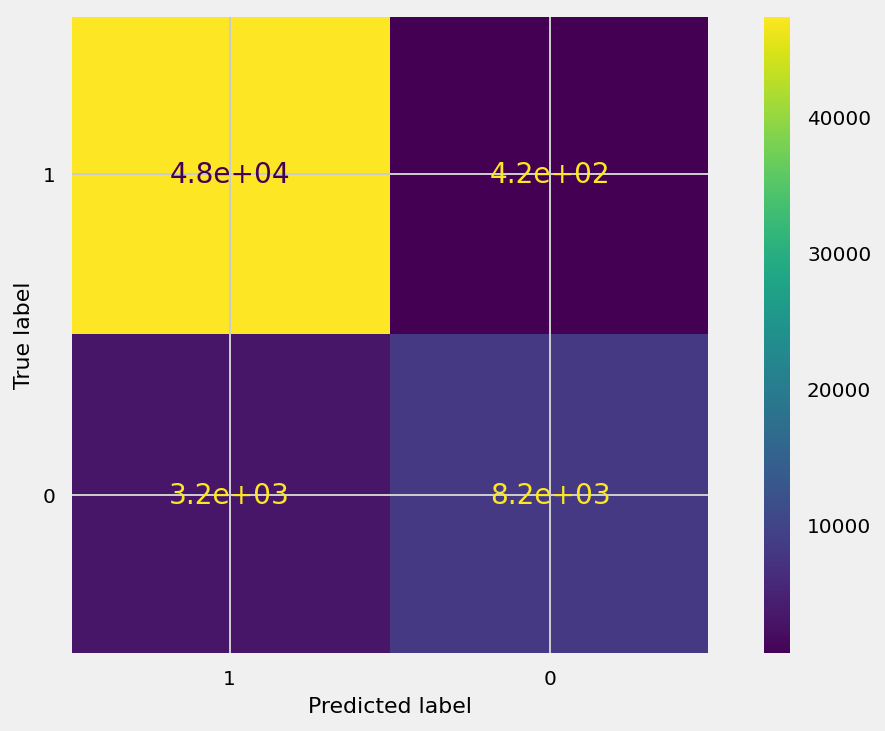

In [60]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()

plot_confusion_matrix(testdf['click'], testdf['prediction'], [1, 0])

In [61]:
print(classification_report(testdf['click'], testdf['prediction'], [1, 0]))

              precision    recall  f1-score   support

           1       0.95      0.72      0.82     11446
           0       0.94      0.99      0.96     48033

    accuracy                           0.94     59479
   macro avg       0.94      0.85      0.89     59479
weighted avg       0.94      0.94      0.93     59479



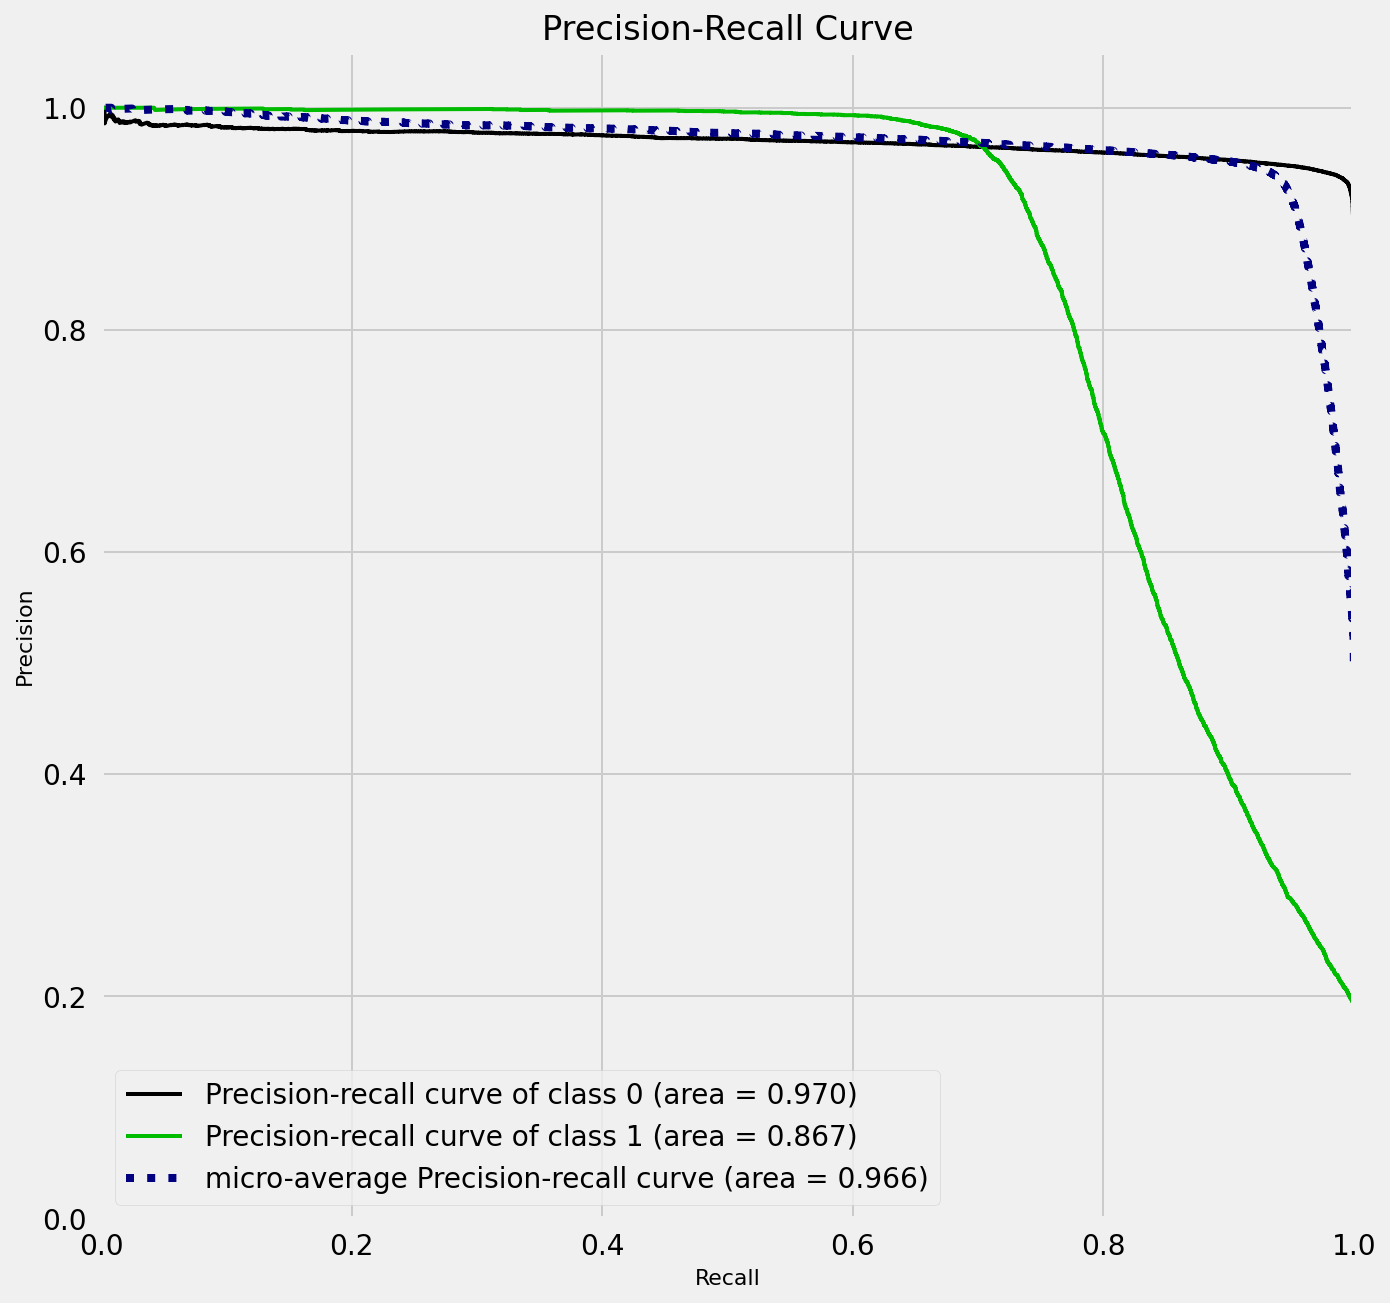

In [63]:
skplt.metrics.plot_precision_recall(testdf['click'].values, testdf[['prediction_conf0', 'prediction_conf1']].values, classes_to_plot=[0, 1], figsize=(10,10));

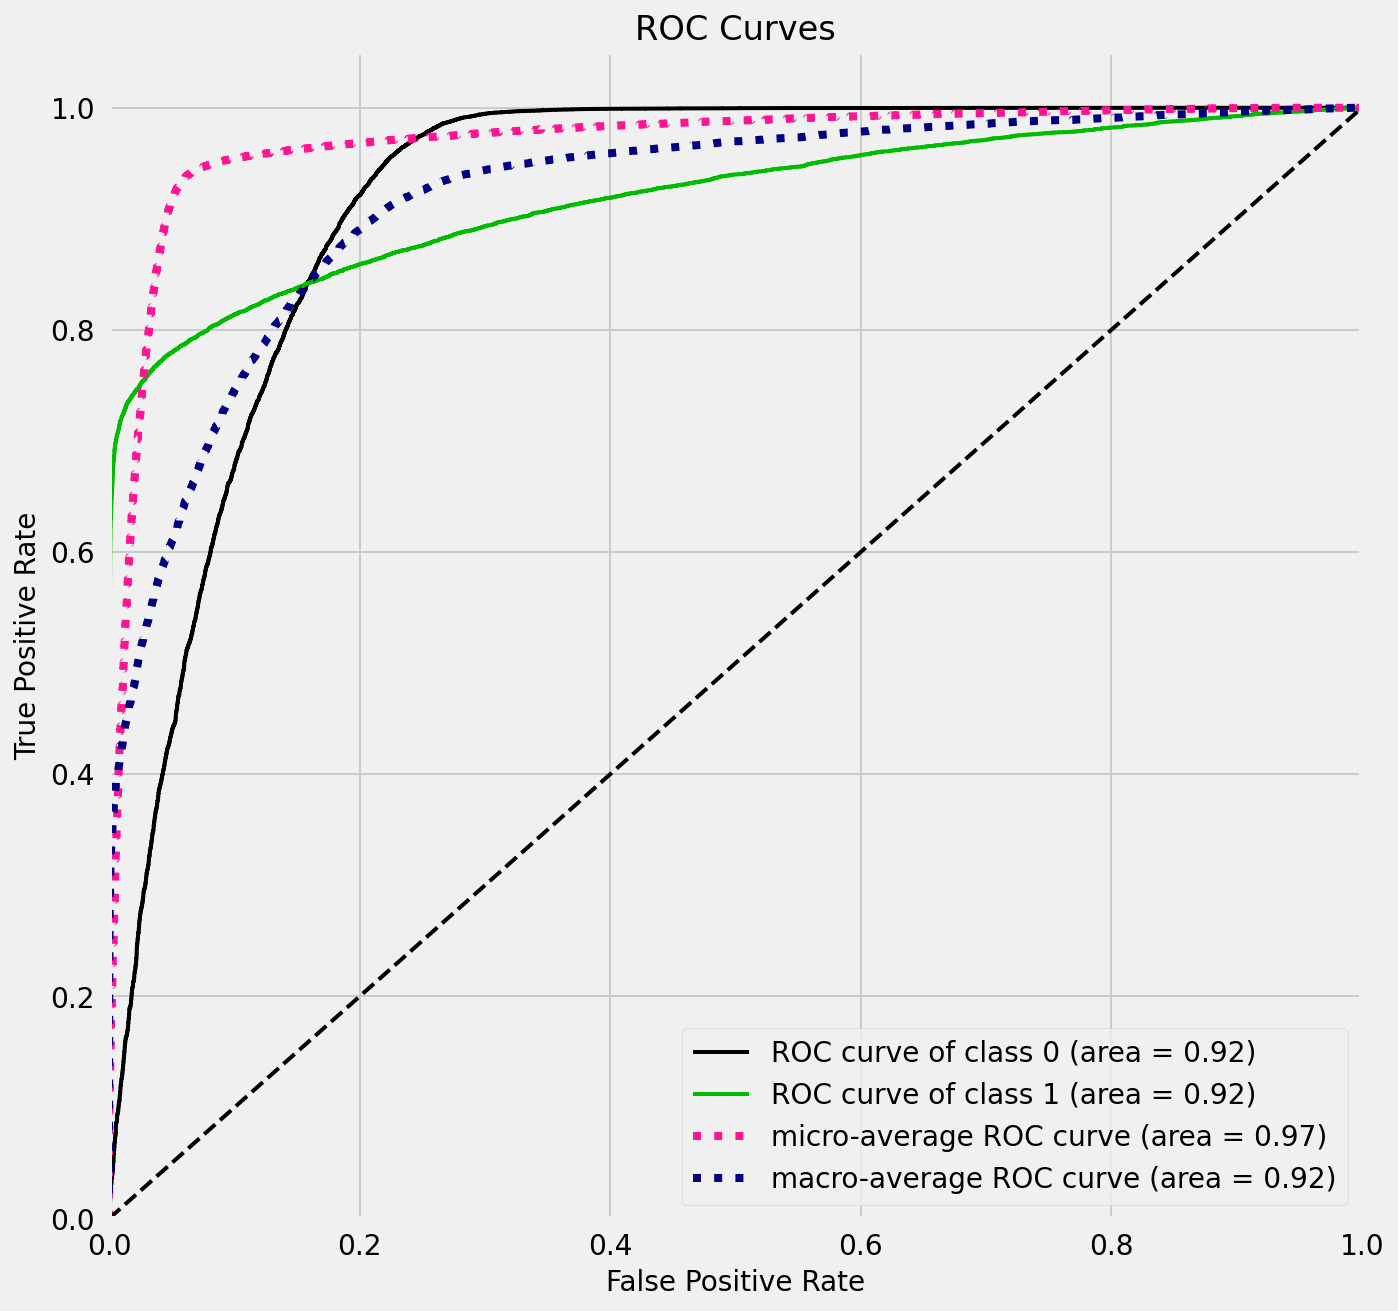

In [64]:
skplt.metrics.plot_roc_curve(testdf['click'].values, testdf[['prediction_conf0', 'prediction_conf1']].values, figsize=(10,10));

## Visualizing outputs
Doing some sanity checks to figure if the model outputs make sense. Randomly taking an user id and checking the titles from train clicks and predicted clicks.

In [66]:
def get_wordcloud_for_user(text_list):

    stopwords = set(STOPWORDS).union([np.nan, 'NaN', 'S'])

    wordcloud = WordCloud(
                   max_words=50000,
                   min_font_size =12,
                   max_font_size=50,
                   relative_scaling = 0.9,
                   stopwords=set(STOPWORDS),
                   normalize_plurals= True
    )

    clean_titles = [word for word in text_list if word not in stopwords]
    title_wordcloud = wordcloud.generate(' '.join(clean_titles))

    plt.figure(figsize = (10,10))
    plt.imshow(title_wordcloud, interpolation='bilinear',)
    plt.axis("off")
    plt.show()

In [67]:
# traindf.user_id.value_counts()[44300:44305]
ii = traindf[(traindf['user_id']=="U84756") & (traindf['click']==1)]['item'].unique()
tlist = [news_dict[i]['title'] for i in ii]
# tlist
news_df[news_df['news_id'].isin(ii)]['category'].value_counts()

news             50
lifestyle        44
tv               27
health           22
music            15
foodanddrink     10
movies            7
finance           4
travel            3
entertainment     3
sports            2
autos             1
Name: category, dtype: int64

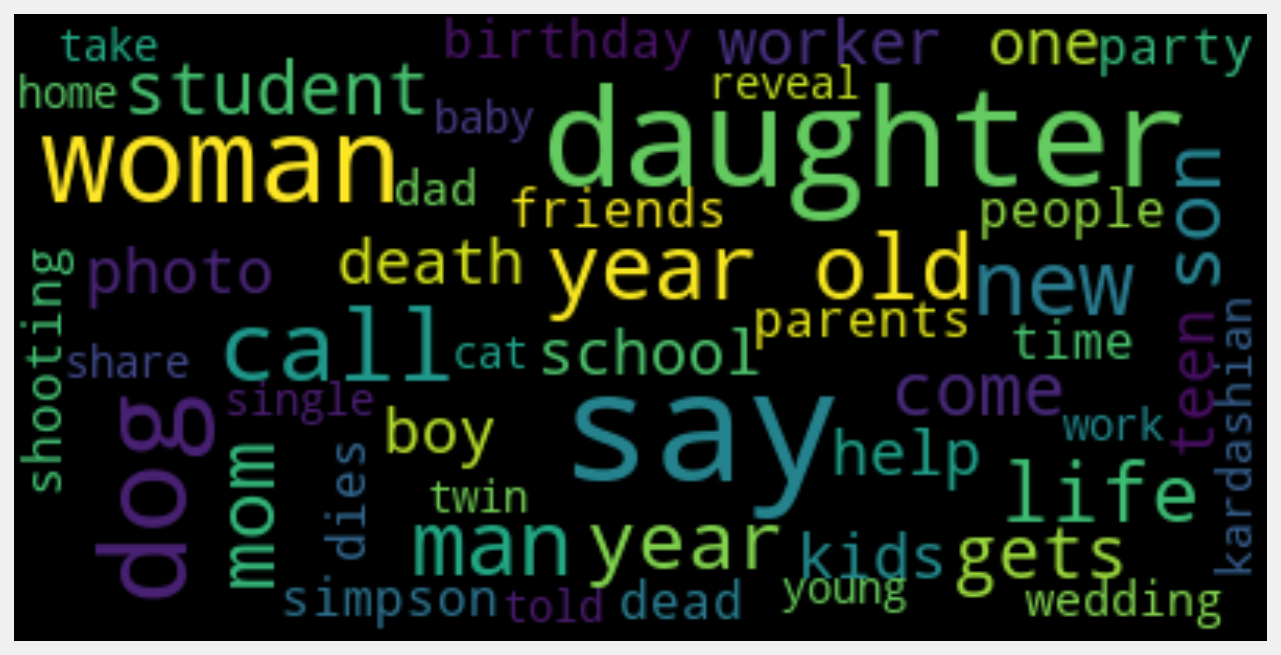

In [68]:
get_wordcloud_for_user(tlist)

In [69]:
ii = testdf[(testdf['user_id']=="U84756") & (testdf['prediction']==1)]['item'].unique()
news_df[news_df['news_id'].isin(ii)]['category'].value_counts()

news            4
music           1
foodanddrink    1
lifestyle       1
travel          1
Name: category, dtype: int64

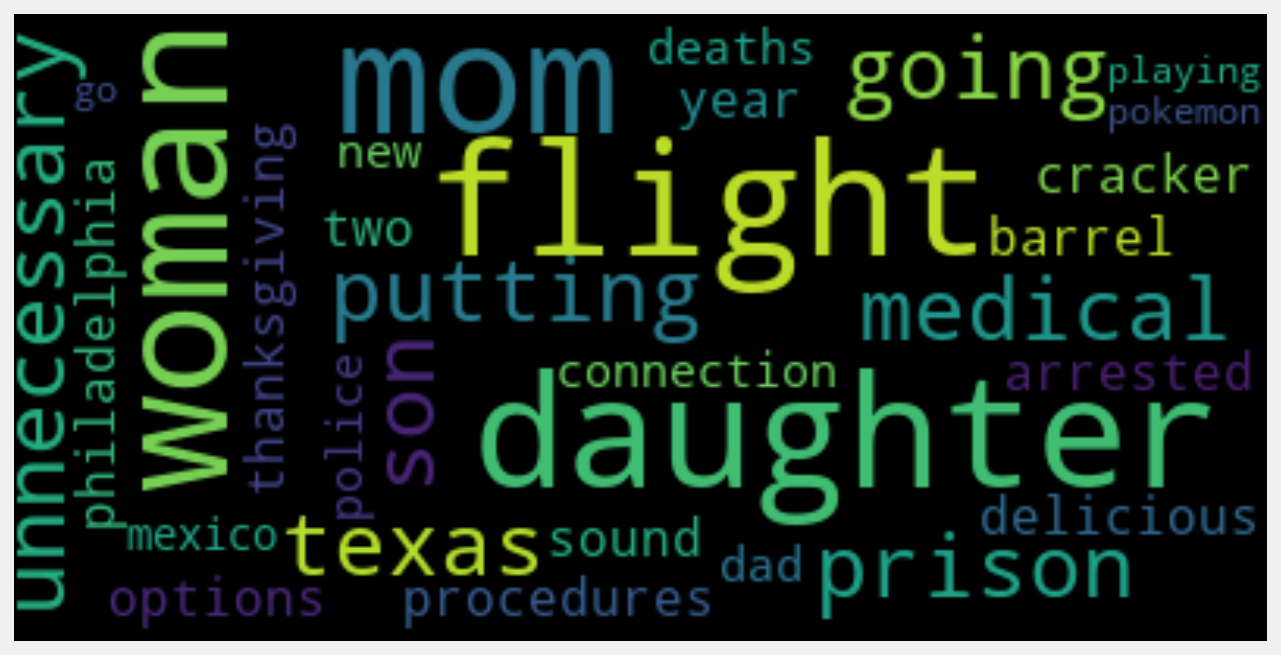

In [70]:
# testdf[testdf['user_id']=="U84756"]
tlist1 = [news_dict[i]['title'] for i in ii]
get_wordcloud_for_user(tlist1)

## Further Improvements

- More feature engineering: user-category affinity score, chronological based train-test split and evaluation, etc
- Hyperparamter tuning: finding the best values for different hyperparams like text embedding method, Neural Net layers and hidden sizes, batch size, epochs, etc.
- Finetuning the prediction probabilty thresholds to find the right balance. i.e, Precision-Recall tradeoff.